Pearson r (ERN vs PSWQ) = -0.220 for 11 subjects


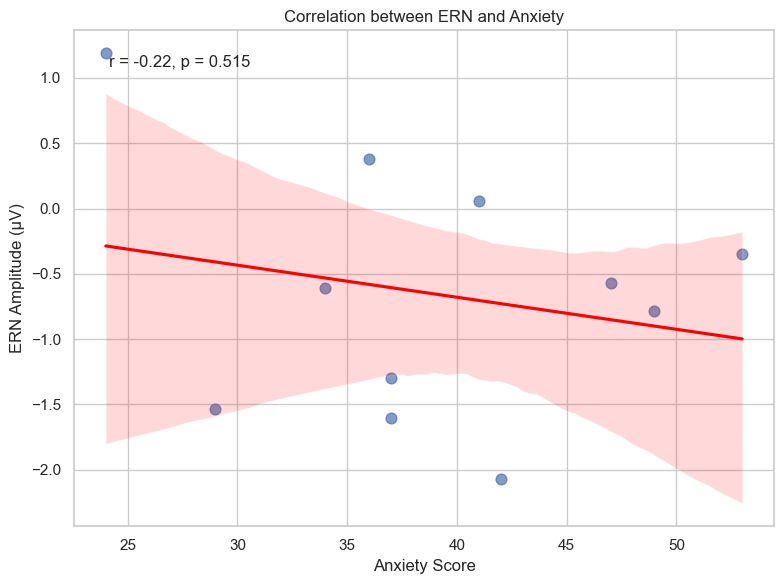

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr

###### Project root directory
PROJECT_ROOT = Path("/Users/zayneb/Desktop/eegmanyanalysts")

###### Where the ERN .tsv files live (in individual subject directories)
ERN_DIR = PROJECT_ROOT / "derivatives" / "ernpipeline"

###### Columns inside each ERN file with the wanted value
ERN_COLUMN = "MeanAmp_µV"
CONDITION_COL = "Condition"
TARGET_CONDITION = "all"

###### Path to the anxiety-scores tsv file
ANX_PATH = PROJECT_ROOT / "participants.tsv"

###### Build a dataframe with one row per participant
ern_rows = []

# Look for subject directories (sub-*)
for subject_dir in ERN_DIR.glob("sub-*"):
    if subject_dir.is_dir():
        # Look for the ERN values file in each subject directory
        ern_file = subject_dir / f"{subject_dir.name}_desc-ernvalues.tsv"
        
        if ern_file.exists():
            pid = subject_dir.name  # e.g., "sub-AG04EN28"
            
            try:
                df = pd.read_csv(ern_file, sep="\t") 
                
                # Keep only rows where the condition is all
                rows_all = df[df[CONDITION_COL].str.lower() == TARGET_CONDITION]
                
                if rows_all.empty:
                    # Either the file has no "all" condition or the label is spelled differently
                    print(f"No '{TARGET_CONDITION}' rows in {ern_file.name}; skipping.")
                    continue
                
                # Extract ERN value (handle potential array format)
                ern_val = rows_all[ERN_COLUMN].astype(str).str.strip("[]").astype(float).mean()
                ern_rows.append({"participant": pid, "ern": ern_val})
                
            except Exception as e:
                print(f"Error processing {ern_file.name}: {e}")
                continue
        else:
            print(f"ERN values file not found for {subject_dir.name}")

ern_df = pd.DataFrame(ern_rows)

###### Extracting anxiety scores and normalising IDs
ANX_ID_COL = "participant_id"
ANX_SCORE_COL = "PSWQ"

# Load anxiety data 
anx_df = pd.read_csv(ANX_PATH, sep="\t")


# Rename and clean the participant ID column
anx_df = anx_df.rename(columns={ANX_ID_COL: "participant"})
anx_df["participant"] = anx_df["participant"].str.strip()

###### Merging the two tables
df = ern_df.merge(anx_df[["participant", ANX_SCORE_COL]], on="participant", how="inner")

###### Computing correlation
r = df["ern"].corr(df[ANX_SCORE_COL])
print(f"Pearson r (ERN vs {ANX_SCORE_COL}) = {r:.3f} for {len(df)} subjects")


###### Plotting correlation
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x=ANX_SCORE_COL, y="ern", scatter_kws={"s": 60, "alpha": 0.7}, line_kws={"color": "red"})
plt.title("Correlation between ERN and Anxiety")
plt.xlabel("Anxiety Score")
plt.ylabel("ERN Amplitude (µV)")

# Add cor statistics to the plot
r_val, p_val = pearsonr(df[ANX_SCORE_COL], df["ern"])
plt.text(
    0.05, 0.95,
    f"r = {r_val:.2f}, p = {p_val:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()


In [16]:
####################
# INTERACTIVE PLOT # 
####################


import plotly.graph_objects as go

# Get x and y
x = df["PSWQ"]
y = df["ern"]
names = df["participant"]

# Fit regression line
slope, intercept = np.polyfit(x, y, deg=1)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = slope * line_x + intercept

# Build figure
fig = go.Figure()

# Add scatter points
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    text=names,
    hovertemplate="<b>%{text}</b><br>PSWQ = %{x}<br>ERN = %{y:.2f} µV",
    marker=dict(size=10, opacity=0.7),
    name="Participants"
))

# Add regression line
fig.add_trace(go.Scatter(
    x=line_x,
    y=line_y,
    mode='lines',
    line=dict(color='red', width=2),
    name="Regression line"
))

# Layout
fig.update_layout(
    title="Correlation between ERN and PSWQ Anxiety Score",
    xaxis_title="PSWQ anxiety score",
    yaxis_title="ERN amplitude (µV)",
    width=800,
    height=600,
    template="simple_white",
    showlegend=True
)

fig.show()